In [1]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
from scipy.stats import skew
import math
from langdetect import detect
import gensim
sys.path.append("/Users/rohanramesh/Documents/GitHub/Insight_writers/lib/")
from text_processing import ProcessArticle as pa
import suggestions as s

In [2]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt4_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [3]:
# Establish connection with database
client = MongoClient()
# mydb = client["testinsightdb"]
mydb = client["insightwriterdb"]

In [31]:
# preprocessing functions
def clean_text(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
#     txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
#     txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
#     remove_digits = str.maketrans('', '', digits)
#     txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

def clean_text_no_numbers(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
    txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
    txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
    remove_digits = str.maketrans('', '', digits)
    txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

# remove stopwords
def remove_stopwords(word_tokens): # must be tokenized sentence
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

# stem long string - must be tokenized
def stemstr(txtstr):
    ps = PorterStemmer()
    newstr = [ps.stem(curr_word) for curr_word in txtstr]
    return newstr

# for figuring out what type of word
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0] # first indexer for 
            # getting the top POS from list, second indexer for getting POS from tuple( POS: count )

# lemmatize long string - must be tokenized
def lemstr(txtstr):
    lz = WordNetLemmatizer()
    newstr = [lz.lemmatize(curr_word, get_pos(curr_word)) for curr_word in txtstr]
    return newstr

# get number of words
def get_nwords(txtstr):
    b = word_tokenize(txtstr)
    n_words = len(b)
    return n_words

# get number of sentences and nwords per sentences and sentence length variability
def get_nsentences(txtstr):
    b = sent_tokenize(txtstr)
    n_sentences = len(b)
    nwords = []
    for curr_sent in b:
        nwords.append(get_nwords(curr_sent))
    return n_sentences, np.mean(nwords), np.std(nwords)


# nsyll of a word
def nsyl(word):
    d = cmudict.dict()
    output = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    return output


# n syllables of longer string
def n_syllables(txtstr):
    b = word_tokenize(txtstr)
    syll_each_word = []
    for curr_word in b:
        syll_each_word.append(nsyl(curr_word)[0])
    return syll_each_word

# number of words and word length variability
def get_word_length(txtsrt):
    tokens = word_tokenize(txtsrt)
    # Filter out punctuation
    no_punct_tokens = ([token for token in tokens 
                                            if any(c.isalpha() for c in token)])
    # Get a distribution of token lengths
    token_lengths = [len(token) for token in no_punct_tokens]
    return np.mean(token_lengths), np.std(token_lengths), skew(token_lengths)
        

# get flesch kincaid value
def get_fk_value(txtstr):
    # get n sentences
    a = word_tokenize(txtstr)
    n_words = len(a)
    # get n words
    b = sent_tokenize(txtstr)
    n_sentences = len(b)    
    score = 206.835 - 1.015 * (n_words / n_sentences) - 84.6 * (num_syllables / n_words)

# cosine similarity
def cos_sim(vec1,vec2):
    a = dot(vec1, vec2)/(norm(vec1)*norm(vec2))
    return a

def get_sentiments_of_sentences(txtstr):
    analyzer = SentimentIntensityAnalyzer()
    avg_sentim = []
    sentim_var = []
    sentim_all = {}
    sentim_all['neg'] = []
    sentim_all['neu'] = []
    sentim_all['pos'] = []
    sentim_all['compound'] = []
    sentences = sent_tokenize(txtstr)
    for i in sentences:
        vs = analyzer.polarity_scores(i)
        sentim_all['neg'].append(vs['neg'])
        sentim_all['neu'].append(vs['neu'])
        sentim_all['pos'].append(vs['pos'])
        sentim_all['compound'].append(vs['compound'])
    # take avg sentim for each story by averaging sentim for each sentence
    avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                     np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
    # take std of sentim for each story to measure sentiment variability
    sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                     np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    return avg_sentim, sentim_var

def build_feature_vector_for_article(txtstr):
    cleantext = clean_text(txtstr)
    n_words = get_nwords(cleantext)
    n_sentences, n_wordspersentence, n_wordspersent_variability = get_nsentences(txtstr)
    a, b = get_sentiments_of_sentences(txtstr)
    neg_sent = a[0][0]
    neu_sent = a[0][1]
    pos_sent = a[0][2]
    neg_sent_var = b[0][0]
    neu_sent_var = b[0][1]
    pos_sent_var = b[0][2]
    wordlength, wordlength_var, wordlength_skew = get_word_length(txtstr)
    output_vec = [n_words, neg_sent, neu_sent, pos_sent, neg_sent_var, 
                 neu_sent_var, pos_sent_var, n_sentences, 
                 n_wordspersentence, n_wordspersent_variability, 
                 wordlength, wordlength_var, wordlength_skew]
    return output_vec
    
# detect if no english and return a flag
def detect_nonenglish(txtstr):
    b = sent_tokenize(txtstr)
    b = b[0:np.max([10,len(b)])] # take longest of first 10 sentences
    # n words per sentence
    nwords = [len(word_tokenize(i)) for i in b]
    if not nwords:
        output = True
    else:
        idx = nwords.index(np.max(nwords))
        c = detect(b[idx])
        if c != 'en':
            output = True
        else:
            output = False
    return output

In [6]:
curr_name = 'zachlowe_nba'
currcol = mydb[curr_name]
y = currcol.find({"name": curr_name})
curr_art = y[0]

# a, b = get_sentiments_of_sentences(curr_art['article'])
# print(a)
# print(b)
a = build_feature_vector_for_article(curr_art['article'])
print(a)
# cleantext = clean_text(curr_art['article'])
# tokens = word_tokenize(curr_art['article'])

# # Filter out punctuation
# no_punct_tokens = ([token for token in tokens 
#                                         if any(c.isalpha() for c in token)])

# # Get a distribution of token lengths
# token_lengths = [len(token) for token in no_punct_tokens]
# print(skew(token_lengths))

[2966, 0.0781081081081081, 0.839637837837838, 0.08224864864864866, 0.1340543221444573, 0.18581430333818436, 0.14342242581933823, 185, 19.854054054054053, 17.212669667374644, 4.801696020874103, 2.667324884968783, 1.4024073650027438]


In [7]:
# lets build corpus of all writers sampling 10 articles from each author
def build_corpus_delta_method(authors, npieces_sample, mydb):
    t = time.time()
    # authors = ['zachlowe_nba', 'marc-stein', 'howard-beck']

    # Combine every paper except our test case into a single corpus
    whole_corpus = []
    all_tokens_by_author = {}
    for curr_name in authors:
        currcol = mydb[curr_name]
        y = currcol.find({"name": curr_name})
        ninsample = y.count()
        article_idx_to_sample = random.sample(range(0,ninsample), np.min([ninsample,npieces_sample]))
        # for saving tokens for later - compile across all articles included
        all_tokens_by_author[curr_name] = []
        for i in article_idx_to_sample:
            tokens = word_tokenize(y[i]['article'])
            # Filter out punctuation
            no_punct_tokens = ([token for token in tokens 
                                                    if any(c.isalpha() for c in token)])
            all_tokens_by_author[curr_name] += no_punct_tokens
            whole_corpus += no_punct_tokens

    # Get a frequency distribution
    whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
    whole_corpus_freq_dist[ :10 ]

    # The main data structure
    features = [word for word,freq in whole_corpus_freq_dist]
    feature_freqs = {}

    for curr_name in authors:
        # A dictionary for each candidate's features
        feature_freqs[curr_name] = {} 

    #     # A helper value containing the number of tokens in the author's subcorpus
        overall = len(all_tokens_by_author[curr_name])
        if overall == 0:
            overall = 1

        # Calculate each feature's presence in the subcorpus
        for feature in features:
            presence = all_tokens_by_author[curr_name].count(feature)
            feature_freqs[curr_name][feature] = presence / overall

    # The data structure into which we will be storing the "corpus standard" statistics
    corpus_features = {}

    # For each feature...
    for feature in features:
        # Create a sub-dictionary that will contain the feature's mean 
        # and standard deviation
        corpus_features[feature] = {}

        # Calculate the mean of the frequencies expressed in the subcorpora
        feature_average = 0
        for curr_name in authors:
            feature_average += feature_freqs[curr_name][feature]
        feature_average /= len(authors)
        corpus_features[feature]["Mean"] = feature_average

        # Calculate the standard deviation using the basic formula for a sample
        feature_stdev = 0
        for curr_name in authors:
            diff = feature_freqs[curr_name][feature] - corpus_features[feature]["Mean"]
            feature_stdev += diff*diff
        feature_stdev /= (len(authors) - 1)
        feature_stdev = math.sqrt(feature_stdev)
        corpus_features[feature]["StdDev"] = feature_stdev

    feature_zscores = {}
    for curr_name in authors:
        feature_zscores[curr_name] = {}
        for feature in features:

            # Z-score definition = (value - mean) / stddev
            # We use intermediate variables to make the code easier to read
            feature_val = feature_freqs[curr_name][feature]
            feature_mean = corpus_features[feature]["Mean"]
            feature_stdev = corpus_features[feature]["StdDev"]
            feature_zscores[curr_name][feature] = ((feature_val-feature_mean) / 
                                                feature_stdev)
    return feature_zscores, corpus_features
    elapsed = time.time() - t
    print(elapsed)
    
# get delta values for a given test case
def get_delta_values(feature_zscores, corpus_features, article):
    # tokenize
    testcase_tokens = word_tokenize(article)

    # Filter out punctuation and lowercase the tokens
    testcase_tokens = [token.lower() for token in testcase_tokens 
                       if any(c.isalpha() for c in token)]

    # Calculate the test case's features
    overall = len(testcase_tokens)
    if overall == 0:
        overall = 1
    testcase_freqs = {}
    for feature in features:
        presence = testcase_tokens.count(feature)
        testcase_freqs[feature] = presence / overall

    # Calculate the test case's feature z-scores
    testcase_zscores = {}
    for feature in features:
        feature_val = testcase_freqs[feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    #     print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

    author_deltas = []
    for author in authors:
        delta = 0
        for feature in features:
            delta += math.fabs((testcase_zscores[feature] - 
                                feature_zscores[author][feature]))
        delta /= len(features)
    #     print( "Delta score for candidate", author, "is", delta )
        author_deltas.append(delta)

    output_df = pd.DataFrame.from_dict({'deltas': author_deltas, "author_list": authors})
    return output_df

In [168]:
author_list = list(set(writer_feature_df['author_list']))
feature_zscores, corpus_features = build_corpus_delta_method(author_list, 200, mydb)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if sys.path[0] == '':


In [615]:
test_instance = random.sample(authors,1)[0]
currcol = mydb[test_instance]
y = currcol.find({"name": test_instance})
ninsample = y.count()
article_idx_to_sample = random.sample(range(0,ninsample), 1)
article = y[article_idx_to_sample[0]]['article']
a = get_delta_values(feature_zscores, corpus_features, article)
idx = a['author_list'] == test_instance
print(a[idx])
a.sort_values(by='deltas').head()

       deltas    author_list
110  1.863341  krishna-narsu


/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  after removing the cwd from sys.path.


,deltas,author_list
24,1.740986,rory-masterson
69,1.753353,coley-mick
108,1.787263,kevin-parrish
55,1.788838,david-thorpe
43,1.792859,mason-ginsberg


In [268]:
# iterate through each article collect all deltas and save in list to look at truth for comps
author_similarity_delta = {}
for curr_name in author_list:
    author_similarity_delta[curr_name] = []
    # curr_name = 'zachlowe_nba'
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    across_articles_delta = []
    for curr_art in y: 
        # curr_art = y[1]
        outputdf = get_delta_values(feature_zscores, corpus_features, curr_art['article'])
        curr_delta_sim = [] # for this article
        for name_comp in author_list:
            idx = outputdf['author_list'] == name_comp
            r = outputdf['deltas'][idx].tolist()
            curr_delta_sim.append(r[0])
        across_articles_delta.append(curr_delta_sim)
    author_similarity_delta[curr_name].append(across_articles_delta)

In [278]:
np.shape(author_similarity_delta['zachlowe_nba'][0])[0]

400

In [300]:
deltas_authors_v_authors = np.ndarray(shape=(len(author_list),len(author_list)))
for r in range(0,len(author_list)):
    curr_name = author_list[r]
    narticles = np.shape(author_similarity_delta[curr_name][0])[0]
    # these are all articles
#     sim_to_author = []
    for i in range(0,len(author_list)):
        curr_art_sim = []
        for curr_art_n in range(0,narticles):
            curr_art_sim.append(author_similarity_delta[curr_name][0][curr_art_n][i])
        deltas_authors_v_authors[r,i] = np.mean(curr_art_sim)
    #     sim_to_author.append(np.median(curr_art_sim))

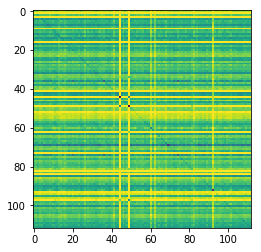

In [302]:
# tmp_df = pd.DataFrame.from_dict({'sim': sim_to_author, 'auth': author_list})
# tmp_df.sort_values(by='sim').head(10)
plt.imshow(deltas_authors_v_authors)
plt.clim(0,3)

In [4]:
# detect if no english and return a flag
def detect_nonenglish(txtstr):
    b = sent_tokenize(txtstr)
    b = b[0:np.max([10,len(b)])] # take longest of first 10 sentences
    # n words per sentence
    nwords = [len(word_tokenize(i)) for i in b]
    if not nwords:
        output = True
    else:
        idx = nwords.index(np.max(nwords))
        c = detect(b[idx])
        if c != 'en':
            output = True
        else:
            output = False
    return output

In [21]:
# add some basic features for each article
mongo_id = []
n_words = []
n_sentences = []
n_wordspersentence = []
n_word_sent_var = []
author_list = []
author_id_n = []
n_nouns = []
n_adj = []
n_verb = []
n_adv =[]
wordlength = []
wordlength_var = []
wordlength_skew = []
# for additional authors from sight list
authors_from_site = []
authors_from_mr = []
# for sentiment analysis
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
# iterate over all writers
for ii in range(0,np.shape(writer_df)[0]):
    #     curr_name in writer_df['website_name']
    curr_name = writer_df['website_name'][ii]
    curr_name_full = writer_df['Idea Text'][ii]
    print(curr_name)
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        a = detect_nonenglish(curr_art['article'])
        if a == True:
            continue
        # mongo id number
        mongo_id.append(str(curr_art['_id']))
        # authors from sits
        authors_from_site.append(curr_art['authors'])
        authors_from_mr.append(curr_name_full)
        # n words after cleaning and removing numbers and punctuation
        curr = pa(curr_art['article'])
        curr.clean_text()
    #     cleantext = clean_text(curr_art['article'])
        n_words.append(curr.get_nwords())
        # n sentences
        ns, nw_s, nw_s_var = curr.get_nsentences()
        n_sentences.append(ns)
        n_wordspersentence.append(nw_s)
        n_word_sent_var.append(nw_s_var)
        # author list
        author_list.append(curr_name)
        # author id n
        author_id_n.append(curr_art['writer_id'])
        # remove stopwords from story
        aa = curr.get_pos_article()
        n_nouns.append(aa[0])
        n_adj.append(aa[1])
        n_verb.append(aa[2])
        n_adv.append(aa[3])
        # get word info
        curr_wordlength, curr_wordlength_var, curr_wordlength_skew = curr.get_word_length()
        wordlength.append(curr_wordlength)
        wordlength_var.append(curr_wordlength_var)
        wordlength_skew.append(curr_wordlength_skew)
        aa = curr.get_sentiments_of_sentences()
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([aa[0][0][0], aa[0][0][1], aa[0][0][2], aa[0][0][3]])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([aa[1][0][0], aa[1][0][1], aa[1][0][2], aa[1][0][3]])
    elapsed = time.time() - t
    print(elapsed)

zachlowe_nba
86.40087795257568
adrian-wojnarowski
18.118824005126953
lee-jenkins
37.053638219833374
howardbeck
42.97023606300354
marc-stein
32.9446439743042
ethan-sherwood-strauss
18.524333238601685
jason-concepcion
40.26346492767334
kevin-arnovitz
25.888498783111572
tom-haberstroh
19.78650712966919
nate-duncan
2.9686810970306396
zach-harper
7.6198930740356445
brian-windhorst
28.851887226104736
sam_amick
33.017675161361694
david-aldridge
74.2960376739502
ramona-shelburne
34.93025803565979
jpdabrams
32.2483389377594
kevin-pelton
35.92349410057068
marc-j-spears
47.67526602745056
matt-moore
48.30571436882019
shams-charania
23.989476203918457
kevin-p-oconnor
3.267617702484131
chris-haynes
25.36006999015808
dave-mcmenamin
31.458938121795654
shea-serrano
59.69196271896362
ian-begley
20.550609827041626
rachel-nichols
1.9729032516479492
ben-golliver
52.35324025154114
mike-prada
26.76696491241455
robmahoney
49.67922520637512
tim-macmahon
25.563719987869263
chris-herring
16.321024179458618
bills

In [18]:
aa = curr.get_sentiments_of_sentences()
aa[1][0]

[0.1340543221444573,
 0.18581430333818436,
 0.14342242581933823,
 0.3836873418085804]

In [32]:
# add some basic features for each article
mongo_id = []
n_words = []
n_sentences = []
n_wordspersentence = []
n_word_sent_var = []
author_list = []
author_id_n = []
n_nouns = []
n_adj = []
n_verb = []
n_adv =[]
wordlength = []
wordlength_var = []
wordlength_skew = []
# for additional authors from sight list
authors_from_site = []
authors_from_mr = []
# for sentiment analysis
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
# for more specific pos
# adj, comp adj, super adj, noun, proper sing n, proper pl n, 
# plural n, adv, comp adv, super avd
pos_test = ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNPS', 'NNS', 'RB', 'RBR', 'RBS']
extra_pos = {}
for curr_pos in pos_test:
    extra_pos[curr_pos] = []

# iterate over all writers
for ii in range(0,np.shape(writer_df)[0]):
#     curr_name in writer_df['website_name']
    curr_name = writer_df['website_name'][ii]
    curr_name_full = writer_df['Idea Text'][ii]
    print(curr_name)
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        a = detect_nonenglish(curr_art['article'])
        if a == True:
            continue
        # mongo id number
        mongo_id.append(str(curr_art['_id']))
        # authors from sits
        authors_from_site.append(curr_art['authors'])
        authors_from_mr.append(curr_name_full)
        # n words after cleaning and removing numbers and punctuation
        cleantext = clean_text(curr_art['article'])
        n_words.append(get_nwords(cleantext))
        # n sentences
        ns, nw_s, nw_s_var = get_nsentences(curr_art['article'])
        n_sentences.append(ns)
        n_wordspersentence.append(nw_s)
        n_word_sent_var.append(nw_s_var)
        # author list
        author_list.append(curr_name)
        # author id n
        author_id_n.append(curr_art['writer_id'])
        # remove stopwords from story
        nostopwords = remove_stopwords(word_tokenize(cleantext))
        typesofspeech = [get_pos(i) for i in nostopwords]
        n_nouns.append(typesofspeech.count('n'))
        n_adj.append(typesofspeech.count('a'))
        n_verb.append(typesofspeech.count('v'))
        n_adv.append(typesofspeech.count('r'))
        # get word info
        curr_wordlength, curr_wordlength_var, curr_wordlength_skew = get_word_length(cleantext)
        wordlength.append(curr_wordlength)
        wordlength_var.append(curr_wordlength_var)
        wordlength_skew.append(curr_wordlength_skew)
        sentim_all = {}
        sentim_all['neg'] = []
        sentim_all['neu'] = []
        sentim_all['pos'] = []
        sentim_all['compound'] = []
        sentences = sent_tokenize(curr_art['article'])
        for i in sentences:
            vs = analyzer.polarity_scores(i)
            sentim_all['neg'].append(vs['neg'])
            sentim_all['neu'].append(vs['neu'])
            sentim_all['pos'].append(vs['pos'])
            sentim_all['compound'].append(vs['compound'])
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                         np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                         np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    elapsed = time.time() - t
    print(elapsed)
#         # for more specific pos
#         doc = nlp(curr_art['article'])
#         pos_vec = [token.tag_ for token in doc]        
#         for curr_pos in pos_test:
#             extra_pos[curr_pos].append(pos_vec.count(curr_pos))
          

zachlowe_nba
88.96417689323425
adrian-wojnarowski
13.186499118804932
lee-jenkins
34.65858006477356
howardbeck
35.1933958530426
marc-stein
26.649585247039795
ethan-sherwood-strauss
13.634865999221802
jason-concepcion
33.93583703041077
kevin-arnovitz
21.178604125976562
tom-haberstroh
16.295100927352905
nate-duncan
2.6133999824523926
zach-harper
6.0465779304504395
brian-windhorst
22.315505027770996
sam_amick
25.76047682762146
david-aldridge
64.58556318283081
ramona-shelburne
26.97231411933899
jpdabrams
26.959163904190063
kevin-pelton
26.772833824157715
marc-j-spears
38.28174376487732
matt-moore
39.558594942092896
shams-charania
17.19422173500061
kevin-p-oconnor
2.5963778495788574
chris-haynes
19.024240732192993
dave-mcmenamin
25.42158794403076
shea-serrano
52.04495096206665
ian-begley
15.134117841720581
rachel-nichols
1.5807900428771973
ben-golliver
44.73105597496033
mike-prada
20.88758087158203
robmahoney
42.87683892250061
tim-macmahon
19.277376890182495
chris-herring
12.089689016342163


(array([8.812e+03, 5.294e+03, 4.899e+03, 3.399e+03, 1.692e+03, 9.280e+02,
        6.560e+02, 5.500e+02, 3.700e+02, 2.770e+02, 2.020e+02, 1.040e+02,
        9.500e+01, 5.400e+01, 4.800e+01, 4.300e+01, 3.100e+01, 2.400e+01,
        1.500e+01, 1.600e+01, 1.800e+01, 9.000e+00, 7.000e+00, 1.000e+01,
        4.000e+00, 6.000e+00, 8.000e+00, 3.000e+00, 9.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([3.000000e+00, 3.573200e+02, 7.116400e+02, 1.065960e+03,
        1.420280e+03, 1.774600e+03, 2.128920e+03, 2.483240e+03,
        2.837560e+03, 3.191880e+03, 3.546200e+03, 3.900520e+03,
        4.254840e+03, 4.609160e+03, 4.963480e+03, 5.317800e+03,
        5.672120e+03, 6.026440e+03, 6.380760e+03, 6.735080e+03,
        7.089400e+03, 7.443720e+03, 7.798040e+03, 8.1523

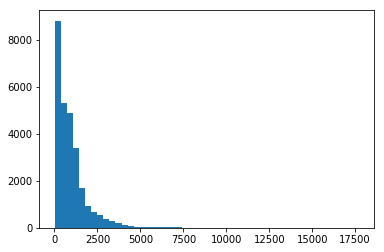

In [33]:
plt.hist(n_words, bins=50)

In [34]:
# build a pd of what we have so far
data = {'n_words': n_words, 'author_id_n': author_id_n, 'author_list': author_list, 'mongo_id': mongo_id,
        'n_nouns': n_nouns, 'n_adj': n_adj, 'n_verb': n_verb, 'n_adv': n_adv, 'n_sentences': n_sentences, 
        'n_wordspersentence': n_wordspersentence, 'n_wordspersent_variability': n_word_sent_var, 
        'neg_sent': [i[0] for i in avg_sentim], 'neu_sent': [i[1] for i in avg_sentim],
        'pos_sent': [i[2] for i in avg_sentim], 'neg_sent_var': [i[0] for i in sentim_var], 
       'neu_sent_var': [i[1] for i in sentim_var], 'pos_sent_var': [i[2] for i in sentim_var], 
       'wordlength': wordlength, 'wordlength_var': wordlength_var, 'wordlength_skew': wordlength_skew, 
       'authors_from_site': authors_from_site, 'authors_from_mr': authors_from_mr}
writer_feature_df = pd.DataFrame.from_dict(data)
writer_feature_df.head()
print(np.shape(writer_feature_df))
writer_feature_df = writer_feature_df.drop_duplicates(subset='wordlength_var')
print(np.shape(writer_feature_df))
writer_feature_df.head()

(27597, 22)
(23246, 22)


,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,n_sentences,n_wordspersentence,...,neu_sent,pos_sent,neg_sent_var,neu_sent_var,pos_sent_var,wordlength,wordlength_var,wordlength_skew,authors_from_site,authors_from_mr
0,2966,693716,zachlowe_nba,5b9dc56f11919a056e11444d,1245,67,413,102,185,19.854054,...,0.839638,0.082249,0.134054,0.185814,0.143422,4.975468,2.747291,1.225534,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe
2,2697,693716,zachlowe_nba,5b9dc57211919a056e11444f,1000,60,363,112,151,20.774834,...,0.869960,0.092225,0.083719,0.139230,0.123817,4.692946,2.482535,1.075665,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe
3,2813,693716,zachlowe_nba,5b9dc57311919a056e114450,1060,58,411,86,183,18.568306,...,0.854087,0.086639,0.106565,0.143424,0.122222,4.717626,2.490510,1.088954,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe
5,2506,693716,zachlowe_nba,5b9dc57511919a056e114452,803,68,393,63,203,15.330049,...,0.887970,0.076966,0.084612,0.164085,0.151518,4.619163,2.516590,1.135553,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe
6,2192,693716,zachlowe_nba,5b9dc57611919a056e114453,849,44,311,76,132,19.704545,...,0.825841,0.108015,0.104941,0.153319,0.130160,4.753343,2.445443,1.056237,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe


In [ ]:
# write to postgresql database for later pulling
# dbname = 'writer_feature_db'
dbname = 'writer_db'
username = 'rohanramesh' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
# writer_feature_df.to_sql('writer_feature', engine, if_exists='replace')

postgres://rohanramesh@localhost/writer_db
True


In [4]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [5]:
# query to load entire db into pandas
sql_query = """
SELECT * FROM writer_feature;
"""
writer_feature_df = pd.read_sql_query(sql_query,con)

In [304]:
#backup
writer_feature_df_backup = writer_feature_df

In [320]:
# # save writer feature df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_4.pickle', 'wb') as handle:
    pickle.dump(writer_feature_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
# with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_2.pickle', 'rb') as handle:
#     writer_feature_df = pickle.load(handle)

In [11]:
# lets build features that will put in
# Features to include:
    # n_words
    # n_nouns/n_words
    # n_adj/n_words
    # n_verb/n_words
    # n_adv/n_words
    # n_sentences
    # n_wordspersentence
    # n_wordspersentence_variability
    # positive sentiment
    # neu sentiment
    # negative sentiment
    # positive sentiment variability
    # neu sentiment variability
    # negative sentiment variability

# do fractions
writer_feature_df['noun_fraction'] = writer_feature_df['n_nouns']/writer_feature_df['n_words']
writer_feature_df['adj_fraction'] = writer_feature_df['n_adj']/writer_feature_df['n_words']
writer_feature_df['adv_fraction'] = writer_feature_df['n_adv']/writer_feature_df['n_words']
writer_feature_df['verb_fraction'] = writer_feature_df['n_verb']/writer_feature_df['n_words']


In [13]:
features_use = ['n_words', 'noun_fraction', 'adj_fraction', 'adv_fraction', 'verb_fraction', 
               'neg_sent', 'pos_sent', 'neu_sent', 'neg_sent_var', 'neu_sent_var', 'pos_sent_var', 
               'n_sentences', 'n_wordspersentence', 'n_wordspersent_variability', 'author_list']
writer_feature_df_2 = writer_feature_df[features_use]
writer_feature_df_2.replace([np.inf, -np.inf], np.nan)
writer_feature_df_2 = writer_feature_df_2.dropna(axis=0, how='any')
# pd.isna(writer_feature_df_2)
print(np.shape(writer_feature_df_2))

(23252, 15)


In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_1 = pd.DataFrame.transpose(writer_feature_df_2)
pca.fit(input_1)
# a = writer_feature_df_2['n_wordspersentence']
# a.isnull().values.any()
a = pca.components_
print(np.shape(a))
plt.plot(a[0],a[1],'o')

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30, 
                  n_iter=1000).fit_transform(writer_feature_df_2.drop('author_list', axis=1))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23252 samples in 0.018s...
[t-SNE] Computed neighbors for 23252 samples in 0.654s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23252
[t-SNE] Computed conditional probabilities for sample 2000 / 23252
[t-SNE] Computed conditional probabilities for sample 3000 / 23252
[t-SNE] Computed conditional probabilities for sample 4000 / 23252
[t-SNE] Computed conditional probabilities for sample 5000 / 23252
[t-SNE] Computed conditional probabilities for sample 6000 / 23252
[t-SNE] Computed conditional probabilities for sample 7000 / 23252
[t-SNE] Computed conditional probabilities for sample 8000 / 23252
[t-SNE] Computed conditional probabilities for sample 9000 / 23252
[t-SNE] Computed conditional probabilities for sample 10000 / 23252
[t-SNE] Computed conditional probabilities for sample 11000 / 23252
[t-SNE] Computed conditional probabilities for sample 12000 / 23252
[t-SNE] Computed conditional probabilities for sam

(23252, 2)


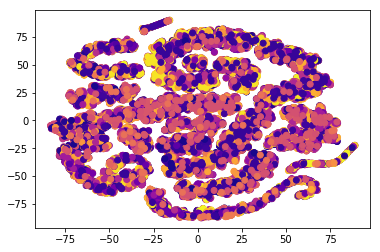

In [15]:
print(np.shape(X_embedded))
all_authors = writer_feature_df_2['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [16]:
# plot red dots for the top 5 recommendations
a = give_author_suggestion_from_author(writer_feature_subsection,'chris-ballard')
print(a['authors'].tolist())
cmap_colors = []
for i in all_authors:
    if i in a['authors'].tolist():
        cmap_colors.append([1,0,0])
    else:
        cmap_colors.append([0.9,0.9,0.9])
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=9,c=cmap_colors[:], alpha=0.1)        
    

NameError: name 'give_author_suggestion_from_author' is not defined

In [26]:
# query
#          AVG("noun_fraction") AS "avg_noun_fraction",
#          AVG("adj_fraction") AS "avg_adj_fraction",
#          AVG("adv_fraction") AS "avg_adv_fraction",


sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent") AS "avg_neg_sent",
         AVG("neu_sent") AS "avg_neu_sent",
         AVG("pos_sent") AS "avg_pos_sent",
         AVG("neg_sent_var") AS "avg_neg_sent_var",
         AVG("neu_sent_var") AS "avg_neu_sent_var",
         AVG("pos_sent_var") AS "avg_pos_sent_var",
        AVG("n_sentences") AS "avg_n_sentences",
        AVG("n_wordspersentence") AS "avg_n_wordspersentence",
        AVG("n_wordspersent_variability") AS "avg_n_wordspersent_variability",
        AVG("wordlength") AS "avg_wordlength",
        AVG("wordlength_var") AS "avg_wordlength_var",
        AVG("wordlength_skew") AS "avg_wordlength_skew",
        "author_list"
FROM writer_feature
WHERE "n_words" > 100
GROUP BY "author_list"
HAVING COUNT(*) > 25 
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')

In [18]:
len(writer_feature_subsection)

80

In [19]:
# normalize new df
def normalize_df(df):
    result = df.copy()
    for feature_name in df.columns:
        if isinstance(df[feature_name][0], str):
            continue
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        result[feature_name] = (df[feature_name] - df[feature_name].mean()) / (df[feature_name].std())
#         result[feature_name] = (df[feature_name]) / norm(df[feature_name])
    return result

# same normalization but on vector
def normalize_vec(list1, means, var):
    output_vec = [(list1[i]-means[i])/var[i] for i in range(0,len(list1))]
    return output_vec
    

norm_writer_feature_subsection = normalize_df(writer_feature_subsection)

In [25]:
writer_feature_df.head()

,index,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,n_sentences,...,pos_sent_var,wordlength,wordlength_var,wordlength_skew,authors_from_site,authors_from_mr,noun_fraction,adj_fraction,adv_fraction,verb_fraction
0,0,2966,693716,zachlowe_nba,5b9dc56f11919a056e11444d,1245,67,413,102,185,...,0.143422,4.801696,2.667325,1.402407,"{""Zach Lowe"",""Adrian Wojnarowski"",""Michael C. ...",Zach Lowe,0.419757,0.022589,0.034390,0.139245
1,2,2697,693716,zachlowe_nba,5b9dc57211919a056e11444f,1000,60,363,112,151,...,0.123817,4.607130,2.427109,1.110728,"{""Zach Lowe"",""Adrian Wojnarowski"",""Michael C. ...",Zach Lowe,0.370782,0.022247,0.041528,0.134594
2,3,2813,693716,zachlowe_nba,5b9dc57311919a056e114450,1060,58,411,86,183,...,0.122222,4.571527,2.405555,1.074744,"{""Zach Lowe"",""Adrian Wojnarowski"",""Michael C. ...",Zach Lowe,0.376822,0.020619,0.030572,0.146107
3,5,2506,693716,zachlowe_nba,5b9dc57511919a056e114452,803,68,393,63,203,...,0.151518,4.445514,2.358147,1.038536,"{""Zach Lowe"",""Adrian Wojnarowski"",""Michael C. ...",Zach Lowe,0.320431,0.027135,0.025140,0.156824
4,6,2192,693716,zachlowe_nba,5b9dc57611919a056e114453,849,44,311,76,132,...,0.130160,4.615350,2.382418,1.197931,"{""Zach Lowe"",""Adrian Wojnarowski"",""Michael C. ...",Zach Lowe,0.387318,0.020073,0.034672,0.141880


In [9]:
X_embedded = TSNE(n_components=2, 
                  verbose=1).fit_transform(norm_writer_feature_subsection.drop('author_list', axis=1))

NameError: name 'TSNE' is not defined

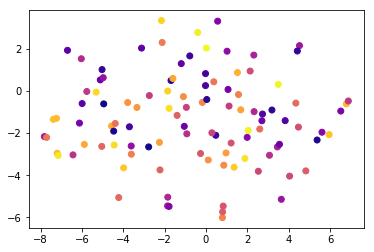

In [479]:
all_authors = writer_feature_subsection['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [20]:
# lets do all pairwise cosine similarities
nvals = np.shape(writer_feature_subsection)[0]
matsim_feat = np.ndarray(shape=(nvals,nvals))
for i in range(0,nvals):
    for j in range(0,nvals):
        vec1 = norm_writer_feature_subsection.iloc[i,:-1].values
        vec2 = norm_writer_feature_subsection.iloc[j,:-1].values
        result1 = cos_sim(vec1, vec2)
        matsim_feat[i, j] = result1

80
(80, 80)


Text(0,0.5,'Authors')

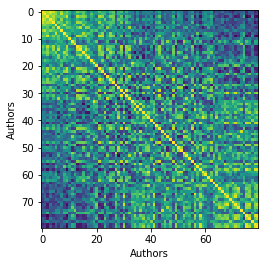

In [21]:
print(len(norm_writer_feature_subsection))
print(np.shape(matsim_feat))
plt.imshow(matsim_feat)
plt.xlabel('Authors')
plt.ylabel('Authors')

In [22]:
def give_suggestions_featurespace(matsim_feat, input_author, author_list):
    idx = author_list.index(input_author)
    tdf = pd.DataFrame.from_dict({'cos_sim': matsim_feat[idx,:], 'authors': author_list})
    a = tdf.sort_values(by='cos_sim', ascending=False)
    return a.iloc[0:5]

# go get the url
def grab_article(article_url):
    article = Article(article_url)
    article.download()
    article.parse()
    article.text
    return article

# def give_suggestion_featurespace_single_article(txtstr, means, stds, norm_feature_df):
def give_suggestion_featurespace_single_article(writer_feature_subsection, txtstr=None, url=None):
    if txtstr is not None:
        vec = build_feature_vector_for_article(txtstr)
    else:
        arti = grab_article(url)
        vec = build_feature_vector_for_article(arti.text)        
    norm_vec = normalize_vec(vec, writer_feature_subsection.mean().tolist(), 
                             writer_feature_subsection.std().tolist())
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list']
    # do similarity test
    similarity_vec = []
    for i in range(0,len(authors)):
        vec1 = norm_feature_df.iloc[i,:-1].values
        result1 = cos_sim(vec1, norm_vec)
        similarity_vec.append(result1)
    tdf = pd.DataFrame.from_dict({'cos_sim': similarity_vec, 'authors': authors})
    output_df = tdf.sort_values(by='cos_sim', ascending=False)
    return output_df.iloc[0:5]
        
def give_suggestions_deltaspace(deltas_authors_v_authors, input_author, author_list):
    idx = author_list.index(input_author)
    tdf = pd.DataFrame.from_dict({'delta_sim': deltas_authors_v_authors[idx,:], 'authors': author_list})
    a = tdf.sort_values(by='delta_sim', ascending=True)
#     a['authors'][0:10]
#     print(a.head(10))
    return a.iloc[0:10]

In [24]:
# b = (writer_feature_subsection.mean().tolist())
# a = (build_feature_vector_for_article(curr_art['article']))
# c = normalize_vec(a, writer_feature_subsection.mean().tolist(), writer_feature_subsection.std().tolist())
# print(c)
arti_url = 'http://www.espn.com/nba/story/_/id/24191536/zach-lowe-jimmy-butler-blake-griffin-nba-supermax'
# arti = grab_article(arti_url)
# curr_name = 'zachlowe_nba'
# currcol = mydb[curr_name]
# y = currcol.find({"name": curr_name})
# print(y.count())
a = give_suggestion_featurespace_single_article(writer_feature_subsection, url=arti_url)
print(a)

ValueError: shapes (16,) and (13,) not aligned: 16 (dim 0) != 13 (dim 0)

In [602]:
tmp_auth_list = norm_writer_feature_subsection['author_list'].tolist()
give_suggestions_featurespace(matsim_feat, 'zachlowe_nba', tmp_auth_list)

,cos_sim,authors
7,1.000000,zachlowe_nba
2,0.886184,lee-jenkins
1,0.878062,chris-ballard
32,0.713748,howardbeck
11,0.698557,jonathan-tjarks


In [381]:
give_suggestions_deltaspace(deltas_authors_v_authors, 'lee-jenkins', author_list)

,delta_sim,authors
4,1.348194,lee-jenkins
17,1.374409,chris-ballard
1,1.447989,ian-oconnor-1027184
25,1.458531,michael-grange
7,1.480210,michael-pina
103,1.492037,adi-joseph
48,1.500533,jpdabrams
19,1.505536,ben-golliver
29,1.506141,zach-harper
23,1.512527,ethan-sherwood-strauss


In [567]:
def give_author_suggestion_from_author(writer_feature_subsection, author):
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list'].tolist()
    if author not in authors:
        return 'blah'
    else:
        idx = authors.index(author)
        norm_vec = norm_feature_df.iloc[idx][:-1]
        # do similarity test
        similarity_vec = []
        for i in range(0,len(authors)):
            vec1 = norm_feature_df.iloc[i,:-1].values
            result1 = cos_sim(vec1, norm_vec)
            similarity_vec.append(round(result1*10,2)) # multiply bu 10 to scale
        tdf = pd.DataFrame.from_dict({'similarity': similarity_vec, 'authors': authors})
        output_df = tdf.sort_values(by='similarity', ascending=False)
        return output_df.iloc[0:5]

In [547]:
writer_feature_subsection.to_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features.pickle')

In [559]:
a = give_author_suggestion_from_author(writer_feature_subsection,'lee-jenkins')

['steve-kyler', 'chris-ballard', 'lee-jenkins', 'dennis-chambers', 'jared-zwerling', 'justin-willard', 'billsimmons', 'zachlowe_nba', 'alex-kennedy', 'david-aldridge', 'shea-serrano', 'jonathan-tjarks', 'james-holas', 'michael-pina', 'mika-honkasalo', 'britt-robson', 'mark-deeks', 'robmahoney', 'dan-devine', 'kevin-pelton', 'michael-lee', 'marc-j-spears', 'ben-golliver', 'tom-haberstroh', 'andrew-sharp', 'trevor-magnotti', 'kevin-arnovitz', 'matt-moore', 'jpdabrams', 'michael-grange', 'paul-flannery', 'seerat-sohi', 'howardbeck', 'showardcooper', 'chris-mannix', 'tim-bontemps', 'zach-harper', 'ramona-shelburne', 'ben-rohrbach', 'bobby-marks', 'paolo-uggetti', 'jason-concepcion', 'neil-paine', 'scott-rafferty', 'keith-smith', 'chris-herring', 'chris-sheridan', 'ken-berger', 'tom-ziller', 'rory-masterson', 'brian-windhorst', 'jeff-siegel', 'mike-prada', 'ethan-sherwood-strauss', 'sam-vecenie', 'david-thorpe', 'dave-mcmenamin', 'ben-falk', 'sam_amick', 'marc-stein', 'blake-murphy', 'tim-m

In [560]:
a

,similarity,authors
2,10.00,lee-jenkins
1,9.70,chris-ballard
7,8.86,zachlowe_nba
9,7.85,david-aldridge
11,7.09,jonathan-tjarks
